## Load libraries

In [1]:
library(gplots, verbose = FALSE);
library(ggplot2, verbose = FALSE);
library(dplyr, verbose = FALSE);
library('Seurat', verbose = FALSE);
library('ArchR', verbose = FALSE);


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||

## Load data

In [ ]:
dataPath <- '/ocean/projects/bio240054p/shared/mouseBrain/Multiome_RNA_ATAC_Mouse_Brain_Alzheimers_AppNote_filtered_feature_bc_matrix.h5'
counts <- Read10X_h5(dataPath)
attributes(counts)

Genome matrix has multiple modalities, returning a list of matrices for this genome



$names
[1] "Gene Expression" "Peaks"

In this project, we will only work with the **Gene Expression** part of this object, representing the results of an **RNA-seq** experiment.

In [ ]:
head(counts$'Gene Expression')
dim(counts$'Gene Expression')

  [[ suppressing 34 column names ‘AAACAGCCAAACTAAG-8’, ‘AAACAGCCAAGCGAGC-10’, ‘AAACAGCCAAGCGATG-9’ ... ]]



6 x 33459 sparse Matrix of class "dgCMatrix"
                                                                              
Xkr4    12 17 26 19 21 . 21 7 12 . 4 . 9 31 19 40 169 . 1 24 . . . . . . 35 24
Gm1992   .  .  .  .  . .  1 .  . . . . .  1  .  1   . . .  . . . . . . .  .  2
Gm19938  .  1  .  .  . .  1 .  . . . . 1  1  .  3   3 . .  . . . . . . .  .  .
Gm37381  .  .  .  .  . .  . .  . . . . .  .  .  .   . . .  . . . . . . .  .  .
Rp1      .  .  .  .  . .  . .  . . . . .  .  .  .   . . .  . . . . . . .  .  .
Sox17    .  .  .  .  . .  . .  . . . . .  .  .  .   . . .  . . . . . . .  .  .
                           
Xkr4    . . . . 14 . ......
Gm1992  . . . .  . . ......
Gm19938 . . . .  1 . ......
Gm37381 . . . .  . . ......
Rp1     . . . .  . . ......
Sox17   . . . .  . . ......

 .....suppressing 33425 columns in show(); maybe adjust options(max.print=, width=)
 ..............................

[1] 32286 33459

## Create Seurat object and subset

In [4]:
cortexSO <- CreateSeuratObject(counts$'Gene Expression')
cortexSO

An object of class Seurat 
32286 features across 33459 samples within 1 assay 
Active assay: RNA (32286 features, 0 variable features)
 1 layer present: counts

We will **downsample** (randomly drop) some of the samples, so that we have a smaller dataset to work with. This is just to ensure that we don't run into memory errors during the analysis.

In [5]:
cortexSubSO <- subset(x = cortexSO, downsample = 15000)
cortexSubSO

An object of class Seurat 
32286 features across 15000 samples within 1 assay 
Active assay: RNA (32286 features, 0 variable features)
 1 layer present: counts

In [6]:
rm(counts)
rm(cortexSO)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,7890693,421.5,13900155,742.4,13900155,742.4
Vcells,76661883,584.9,532403284,4062.0,649450390,4955.0


In [7]:
cortexSubSO[['RNA']]$counts[1:10, 1:3]

10 x 3 sparse Matrix of class "dgCMatrix"
        AAACAGCCAAGCGAGC-10 AAACAGCCAAGCGATG-9 AAACAGCCACAGGGAC-5
Xkr4                     17                 26                 21
Gm1992                    .                  .                  1
Gm19938                   1                  .                  1
Gm37381                   .                  .                  .
Rp1                       .                  .                  .
Sox17                     .                  .                  .
Gm37587                   .                  .                  .
Gm37323                   .                  .                  .
Mrpl15                    .                  .                  1
Lypla1                    .                  .                  1

Warning message:
“Default search for "data" layer in "RNA" assay yielded no results; utilizing "counts" layer instead.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of percent.mt.”


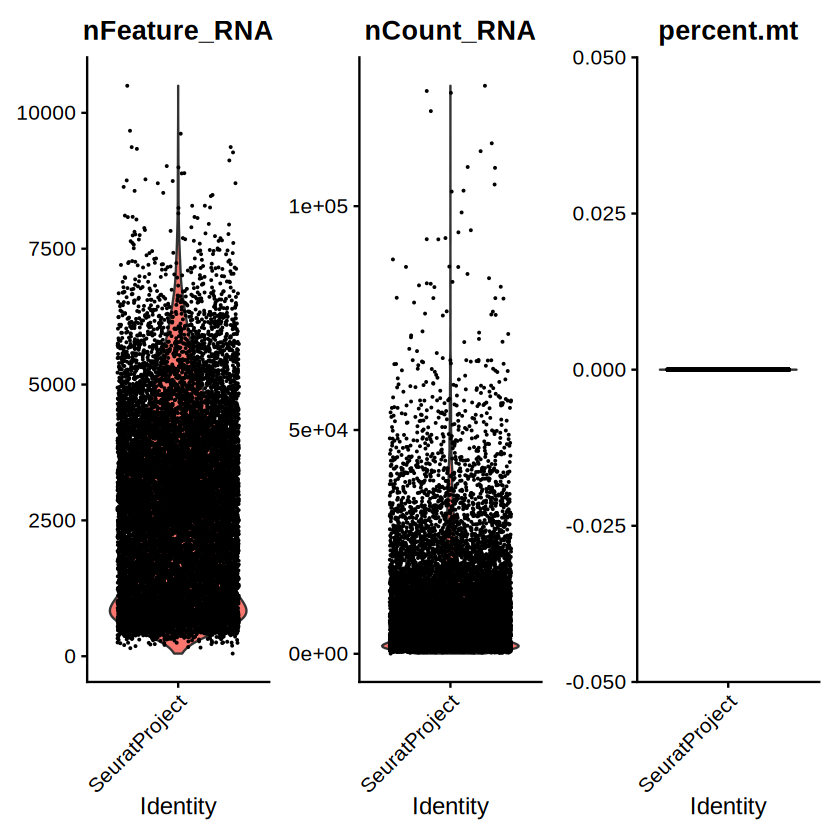

In [8]:
cortexSubSO[["percent.mt"]] <- PercentageFeatureSet(cortexSubSO, pattern = "^MT-")
VlnPlot(cortexSubSO, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

This dataset contains no mitochondrial reads. They were filtered out during an earlier processing step before the above dataset was created.

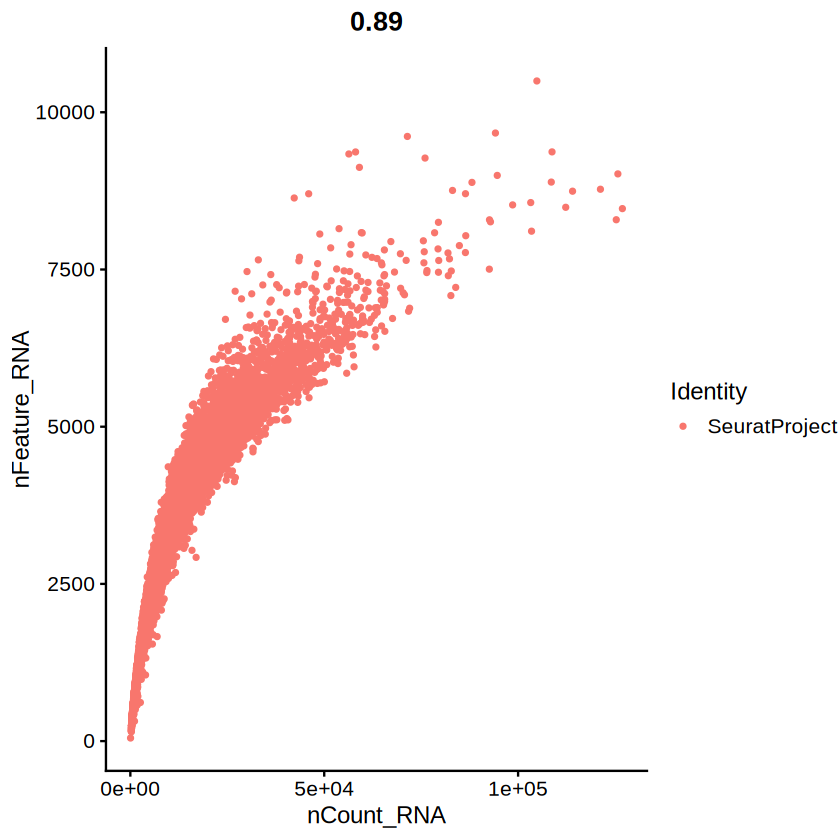

In [9]:
FeatureScatter(cortexSubSO, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")

## Data processing: Normalization, feature selection, scaling

In [10]:
#### Normalize the raw counts ########
cortexSubSO <- NormalizeData(cortexSubSO, normalization.method = "LogNormalize", scale.factor = 10000)
cortexSubSO

Normalizing layer: counts



An object of class Seurat 
32286 features across 15000 samples within 1 assay 
Active assay: RNA (32286 features, 0 variable features)
 2 layers present: counts, data

In [11]:
#### Find variables features ######
cortexSubSO <- FindVariableFeatures(cortexSubSO, selection.method = "vst", nfeatures = 2000)
cortexSubSO

Finding variable features for layer counts



An object of class Seurat 
32286 features across 15000 samples within 1 assay 
Active assay: RNA (32286 features, 2000 variable features)
 2 layers present: counts, data

In [35]:
med.counts <- apply(cortexSubSO[['RNA']]$counts, 1, median)
#print(med.counts)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.6 GiB”


In [36]:
max.median.gene <- names(which.max(med.counts))
max.median.value <- max(med.counts)
cat("Gene with the highest median expression:", max.median.gene, "\n")
cat("Median expression value of that gene:", max.median.value, "\n")


Gene with the highest median expression: Malat1 
Median expression value of that gene: 167 


In [37]:

is.variable <- max.median.gene %in% VariableFeatures(cortexSubSO)
cat("Is the gene", max.median.gene, "a variable feature? ", is.variable, "\n")
if (!is.variable) {
  cat("The gene", max.median.gene, "would not make a good variable feature because it is highly expressed across most cells and does not vary significantly between cell clusters. Variable features are typically genes that show variation across different cell types or clusters, which is crucial for distinguishing between different cell populations.")
} else {
  cat("The gene", max.median.gene, "is a variable feature.")
}


Is the gene Malat1 a variable feature?  FALSE 
The gene Malat1 would not make a good variable feature because it is highly expressed across most cells and does not vary significantly between cell clusters. Variable features are typically genes that show variation across different cell types or clusters, which is crucial for distinguishing between different cell populations.

In [38]:
rm(med.counts)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8308338,443.8,13900156,742.4,13900156,742.4
Vcells,627629360,4788.5,1763431449,13454.0,2235747024,17057.4


In [20]:
#### Scale the data ######
allGenesV <- rownames(cortexSubSO)
cortexSubSO <- ScaleData(cortexSubSO, features = allGenesV)
cortexSubSO

Centering and scaling data matrix



An object of class Seurat 
32286 features across 15000 samples within 1 assay 
Active assay: RNA (32286 features, 2000 variable features)
 3 layers present: counts, data, scale.data

## Principal component analysis (PCA)

In [21]:
#Calculate the principal components of the data
cortexSubSO <- RunPCA(cortexSubSO, features = VariableFeatures(object = cortexSubSO), npcs = 30)

PC_ 1 
Positive:  Apoe, Zbtb20, Slc1a3, Atp1a2, Lama2, Glul, Plpp3, Mertk, Slco1c1, Selenop 
	   Cst3, Gab1, Nhsl1, Prex2, Maml2, Cdh19, Sparc, Plekhg1, Pdlim5, Ccdc141 
	   Gja1, Agmo, S1pr1, Itpr2, Lrmda, Slc39a12, Gm6145, Sparcl1, Htra1, Epas1 
Negative:  Pde10a, Epha6, Cntn5, Cacna2d3, Gria1, Hs6st3, Slit3, Dpp10, Grm1, Camk4 
	   Cntnap5a, Etl4, Cacnb2, Caln1, Hcn1, Mctp1, A830018L16Rik, Neto1, Clstn2, Ryr3 
	   Tenm1, Fstl4, Cdh12, Ano3, Kcnj6, Unc5d, Galnt17, Sv2b, Car10, 2010300C02Rik 
PC_ 2 
Positive:  Prex2, Utrn, Sparcl1, Slco1c1, Atp1a2, Ccdc141, Pitpnc1, Nhsl1, Slc1a2, Slc4a4 
	   Mcc, Ptprz1, 9530026P05Rik, Wwtr1, Rgs20, Gpc5, Epas1, Gli3, Trpm3, Gpc6 
	   S1pr1, Slco1a4, Flt1, Plpp3, Ahnak, Abcb1a, Ghr, Timp3, Ptprb, Gja1 
Negative:  St18, Plp1, Trf, Dock10, Mbp, Mag, Prr5l, D7Ertd443e, Aspa, Mobp 
	   Rnf220, A230001M10Rik, Gm16168, C030029H02Rik, Zfp536, Cldn11, Apod, Mal, Tspan2, Fa2h 
	   Ptgds, Bcas1, Pex5l, Anln, Opalin, A330049N07Rik, Creb5, 4930420G21Rik, Sox2ot,

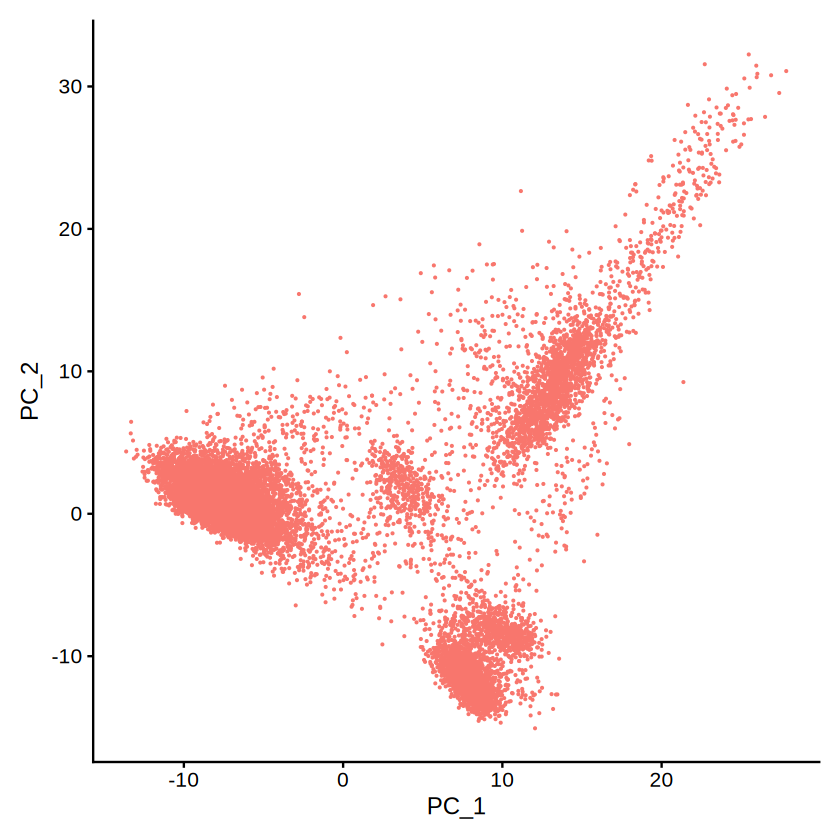

An object of class Seurat 
32286 features across 15000 samples within 1 assay 
Active assay: RNA (32286 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 dimensional reduction calculated: pca

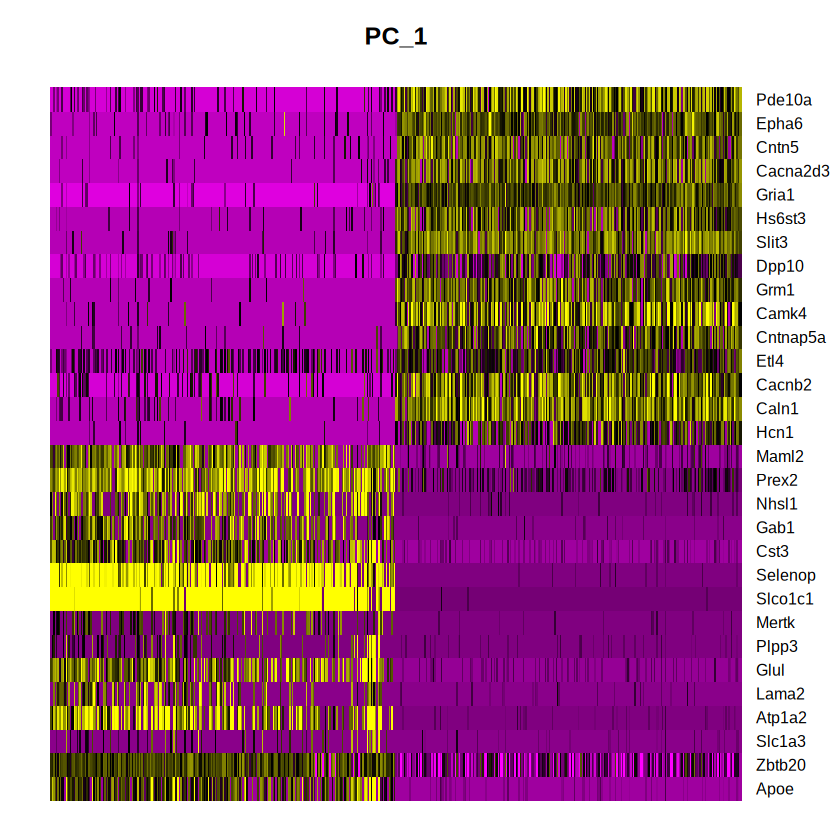

In [22]:
#Plot the results of the PCA
DimPlot(cortexSubSO, reduction = "pca") + NoLegend()
DimHeatmap(cortexSubSO, dims = 1, cells = 500, balanced = TRUE)
cortexSubSO

In [23]:
# Here are the loadings for the PCA dimension reduction.
# The loadings represent meta-genes, or, combinations of genes that
# represent the majority of the varation of gene expression inside this dataset.
loadings <- Loadings(cortexSubSO, reduction = "pca")
loadings[1:20, 1:5]

,PC_1,PC_2,PC_3,PC_4,PC_5
Gm34544,-0.014297493,0.001278070,-0.0014733249,-1.773622e-03,-0.0284178209
Bnc2,0.005925996,0.014563855,-0.0111468540,7.185957e-03,-0.0024744925
Slco1a4,0.037323094,0.059228939,-0.1006405744,-2.925423e-02,-0.0031719543
Vip,-0.006198271,0.002113136,0.0012864855,-1.820843e-03,-0.0010202568
Vtn,0.026544437,0.041139050,-0.0607709884,-1.738084e-02,-0.0007580252
Gfap,0.018510610,0.019974671,0.0172868551,-6.398744e-04,-0.0021873317
Flt1,0.038135139,0.058659630,-0.1017829314,-2.729384e-02,-0.0028527523
Gm32647,-0.030886595,0.013462192,-0.0002515149,3.796545e-03,0.0217205762
Ttr,0.005359180,0.004371404,0.0003458773,-3.608706e-04,0.0036403141
Npsr1,-0.011995463,0.003693076,0.0002164104,-1.281344e-03,-0.0053623716


In [24]:

pca.loadings <- Loadings(cortexSubSO, reduction = "pca")
pca.loadings["Gm34544", ]

PC_1          PC_2          PC_3          PC_4          PC_5 
-0.0142974930  0.0012780699 -0.0014733249 -0.0017736218 -0.0284178209 
         PC_6          PC_7          PC_8          PC_9         PC_10 
 0.0180150444 -0.0053182786  0.0071846092  0.0020490949 -0.0096402805 
        PC_11         PC_12         PC_13         PC_14         PC_15 
 0.0021955235 -0.0028263764  0.0035566109 -0.0019107454  0.0108627235 
        PC_16         PC_17         PC_18         PC_19         PC_20 
 0.0081341158 -0.0389184611  0.0316624701 -0.0219850092  0.0001651803 
        PC_21         PC_22         PC_23         PC_24         PC_25 
-0.0074235595 -0.0084483984  0.0163179720  0.0380255598  0.0084383497 
        PC_26         PC_27         PC_28         PC_29         PC_30 
 0.0015629113 -0.0271798528 -0.0234556290 -0.0508267334 -0.0011193486

## UMAP visualization

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


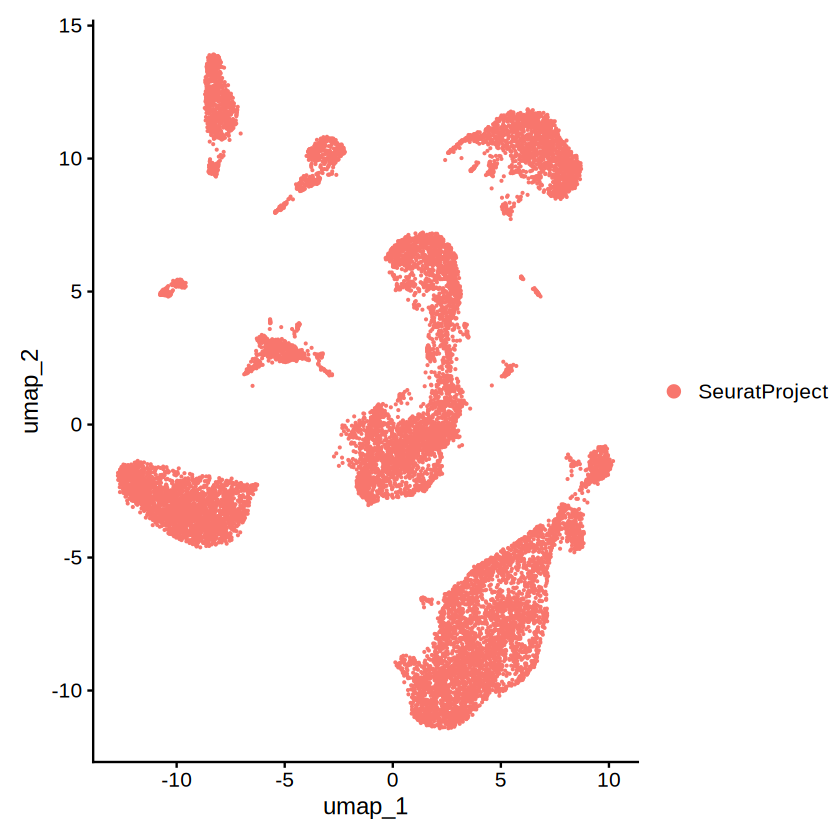

In [25]:
#Create UMAP Dimension Reduction
cortexSubSO <- RunUMAP(cortexSubSO, dims = 1:10, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

## Clustering

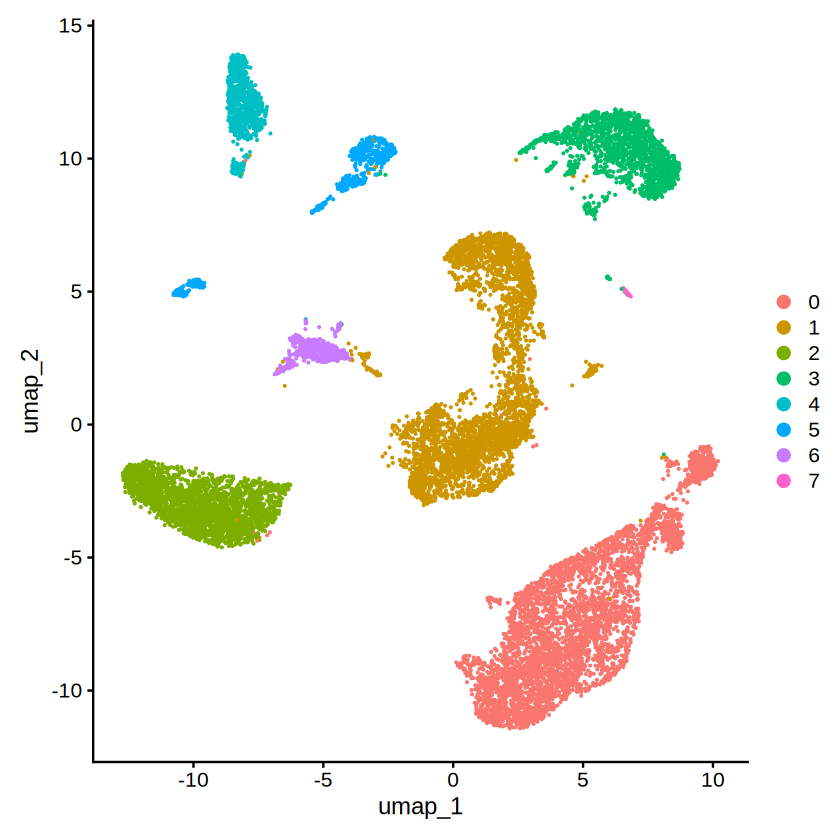

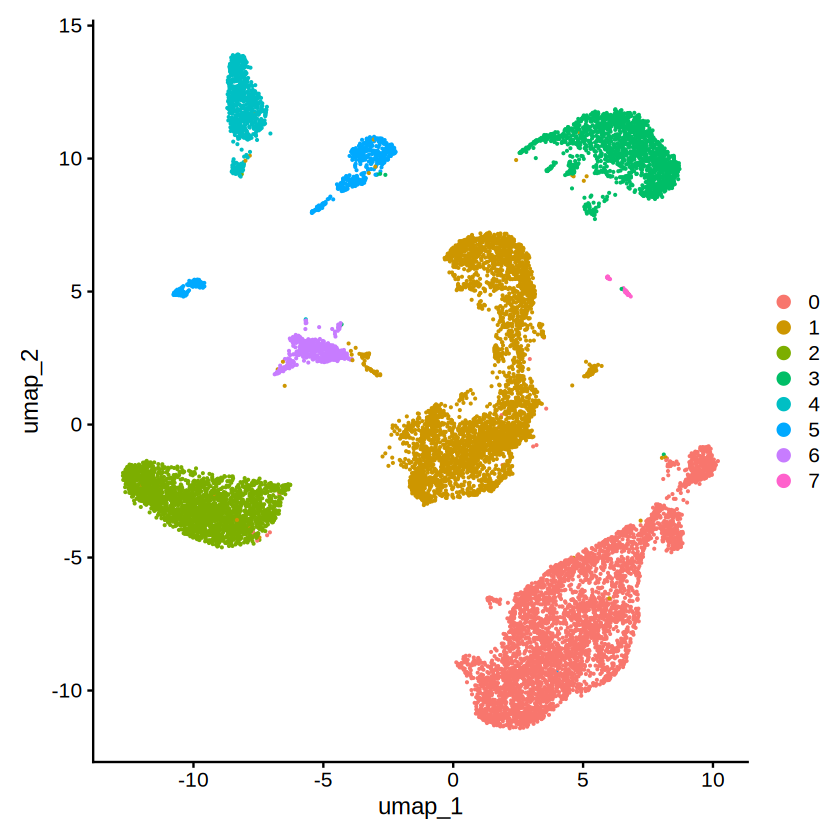

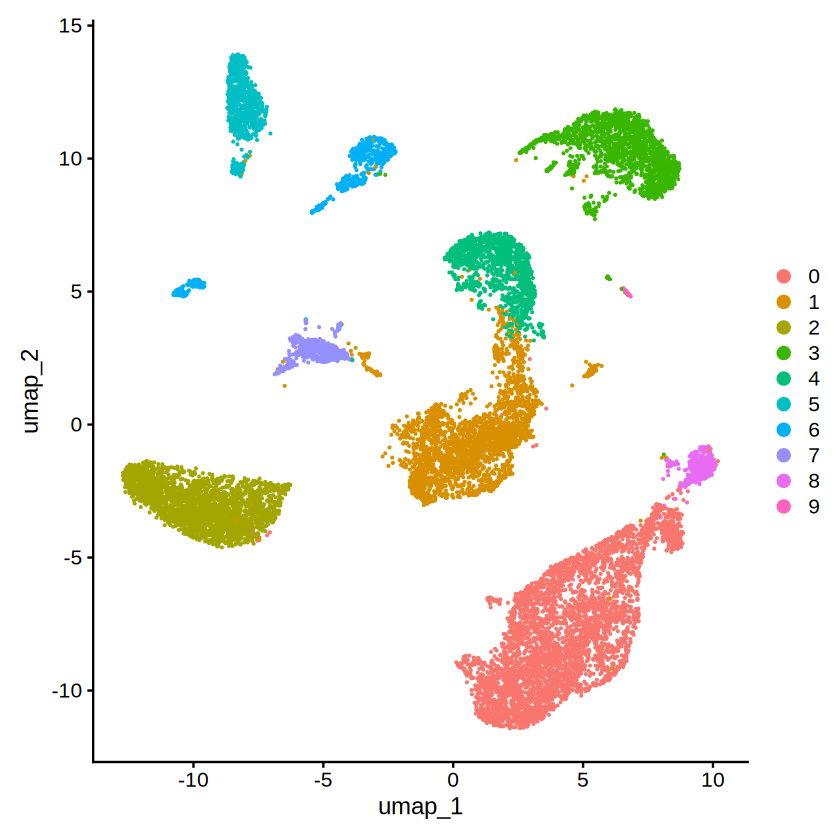

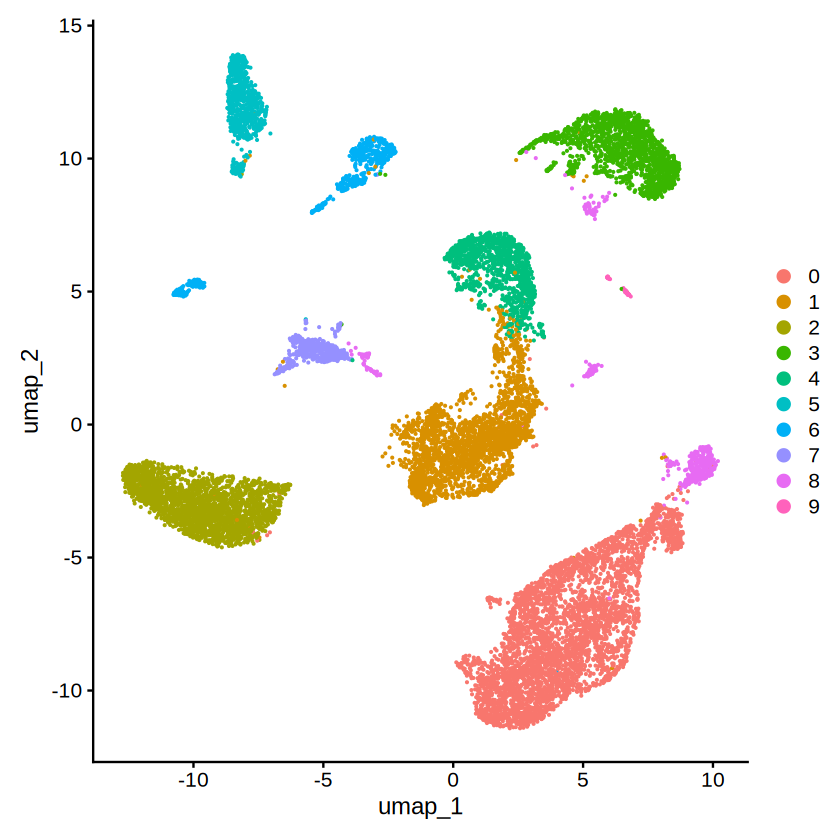

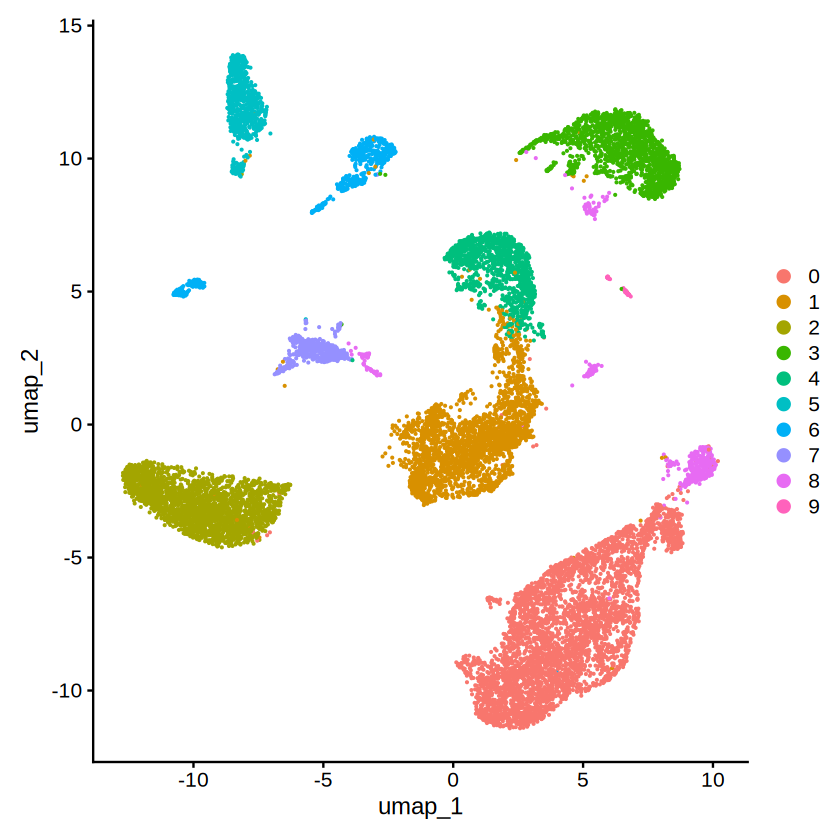

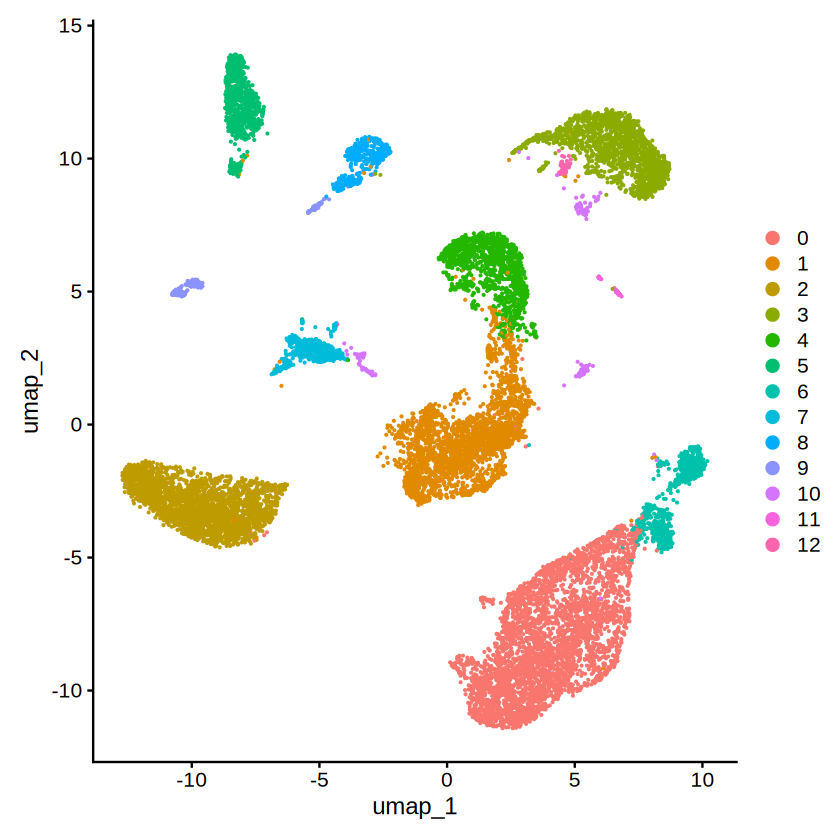

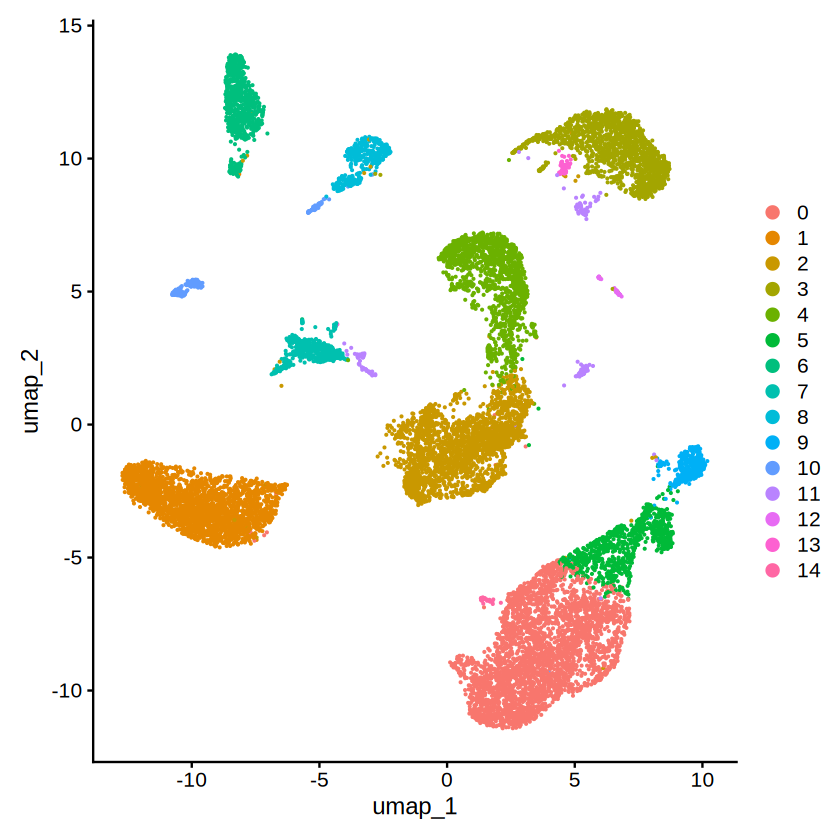

In [26]:
resolution <- 0.02
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

resolution <- 0.04
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

resolution <- 0.06
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

resolution <- 0.08
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

resolution <- 0.1
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

resolution <- 0.2
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

resolution <- 0.3
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
#Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap")

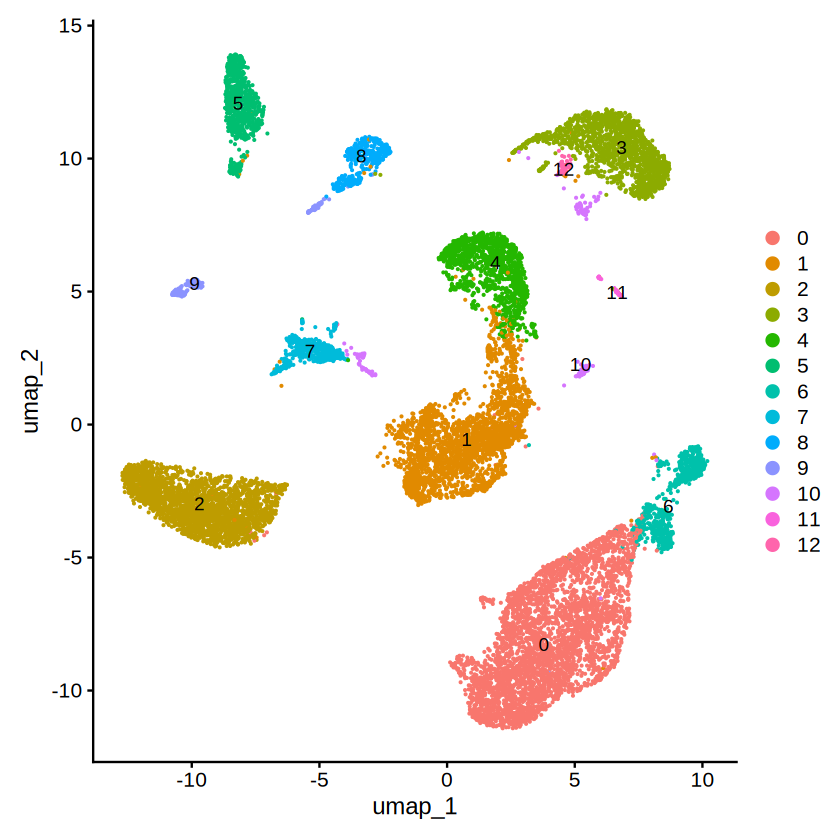

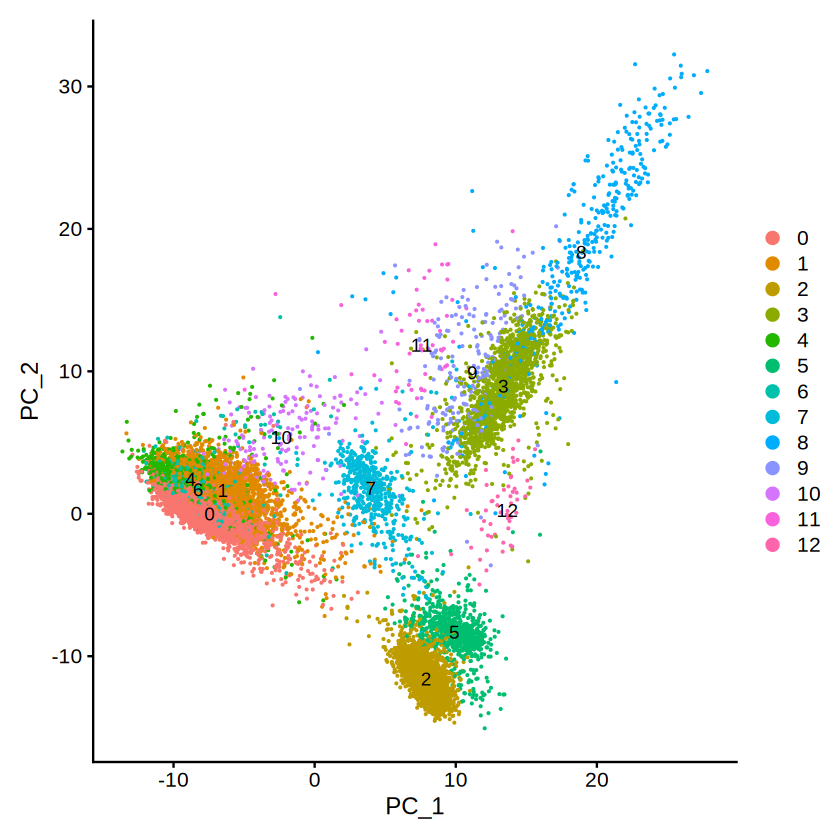

In [28]:
# For the rest of the assignment, we'll cluster with a resolution of 0.2.
resolution <- 0.2
#Create the clustering
cortexSubSO <- FindNeighbors(cortexSubSO, dims = 1:10, verbose = FALSE)
cortexSubSO <- FindClusters(cortexSubSO, resolution = resolution, verbose = FALSE)
# Plot the UMAP
DimPlot(cortexSubSO, reduction = "umap", label=TRUE)
# FYI, we can also plot the PCA reduction using these same clusters:
DimPlot(cortexSubSO, reduction = "pca", label=TRUE)

## Find marker genes

In [29]:

markers.cluster8 <- FindMarkers(cortexSubSO, ident.1 = 8)
head(markers.cluster8)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Flt1,0,9.323668,0.978,0.013,0
Slco1a4,0,10.713270,0.961,0.007,0
Mecom,0,9.064560,0.894,0.011,0
Ptprb,0,8.833044,0.904,0.031,0
Adgrl4,0,10.662536,0.874,0.005,0
Abcb1a,0,8.421918,0.867,0.011,0


In [30]:
markers.cluster5 <- FindMarkers(cortexSubSO, ident.1 = 5)
head(markers.cluster5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Magi2,0,-2.595095,0.165,0.958,0
Ctss,0,8.119075,0.807,0.029,0
Inpp5d,0,8.286263,0.794,0.022,0
Hexb,0,6.782901,0.934,0.164,0
Auts2,0,-3.831718,0.119,0.884,0
Adgrl3,0,-4.706616,0.070,0.833,0


## Marker gene visualization

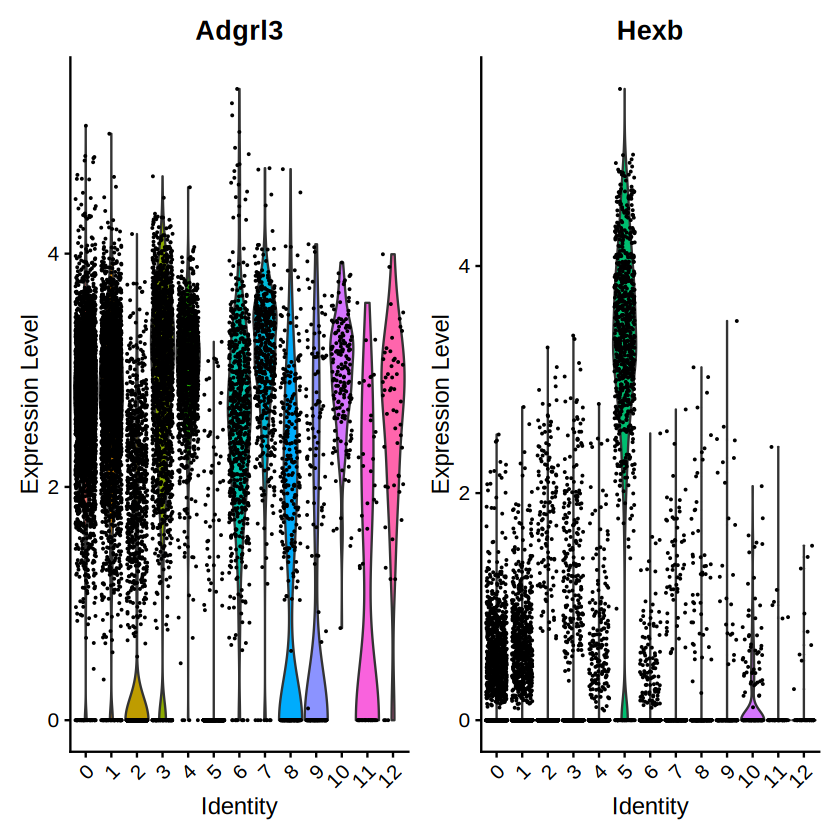

In [31]:

VlnPlot(cortexSubSO, features = c("Adgrl3", "Hexb"), group.by = "seurat_clusters") 

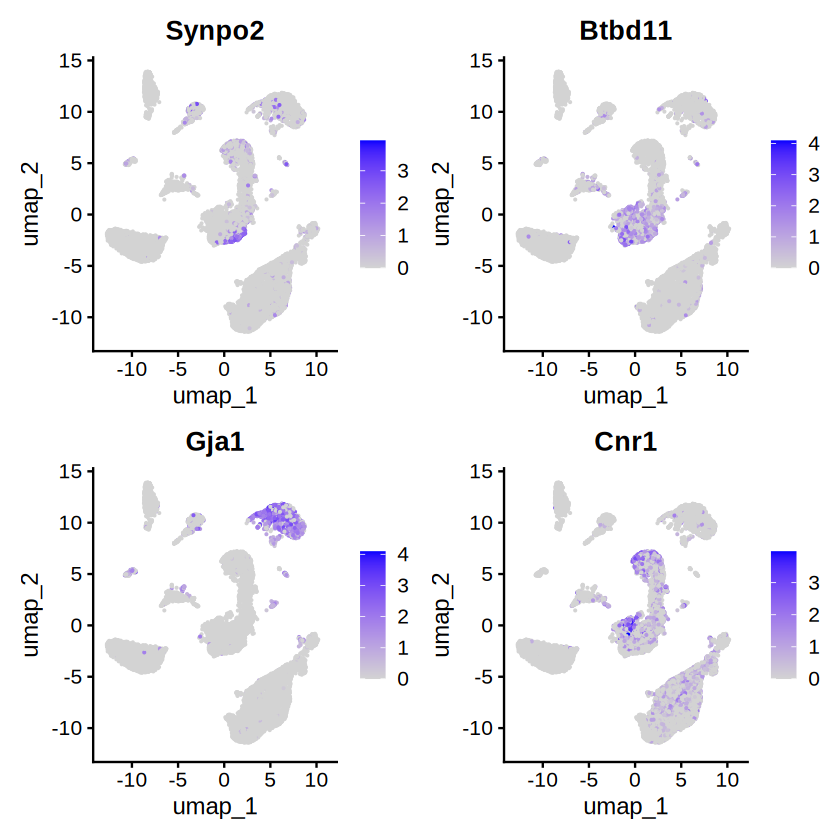

In [32]:

FeaturePlot(cortexSubSO, features = c("Synpo2", "Btbd11", "Gja1", "Cnr1"))


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



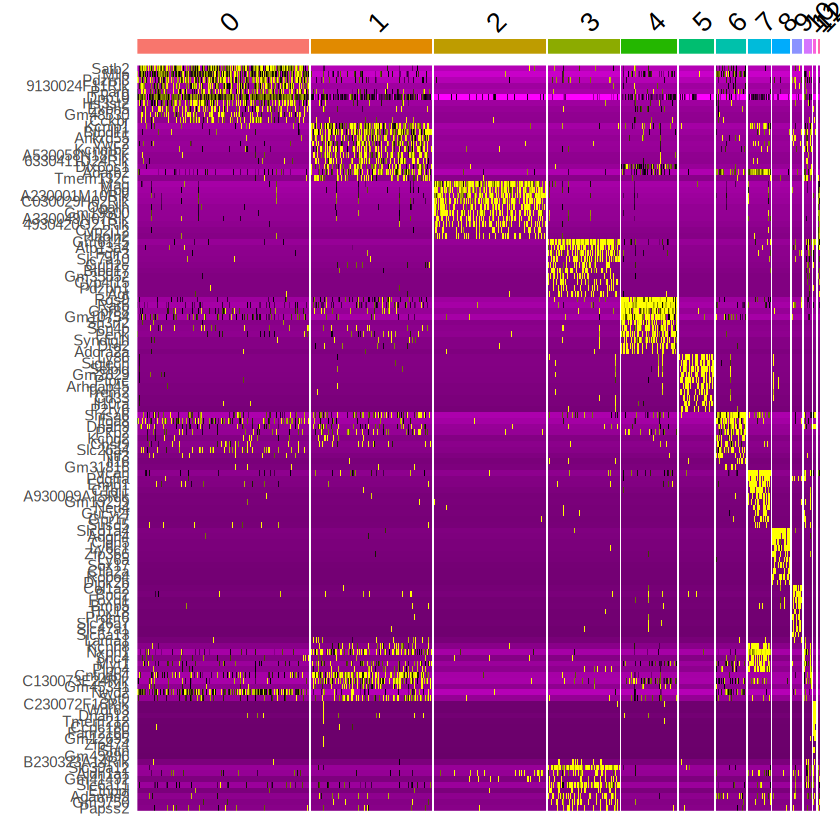

In [33]:

all.markers <- FindAllMarkers(cortexSubSO, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
top10 <- all.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)
DoHeatmap(cortexSubSO, features = top10$gene) + NoLegend()


The genes identified as markers for cluster 6 show relatively weaker and more diffuse expression patterns when compared to the other clusters, which have more distinct and concentrated marker gene expression. This suggests that the marker genes for cluster 6 are not as clearly differentiated from other clusters, leading to potential overlap with neighboring clusters. Such weak or non-specific marker expression can make it difficult to accurately distinguish cluster 6 from the others and may indicate a need for further refinement of the clustering resolution or marker selection process. This ambiguity in cluster 6 marker genes might reflect biological variability, noise, or limitations in the current analysis method.

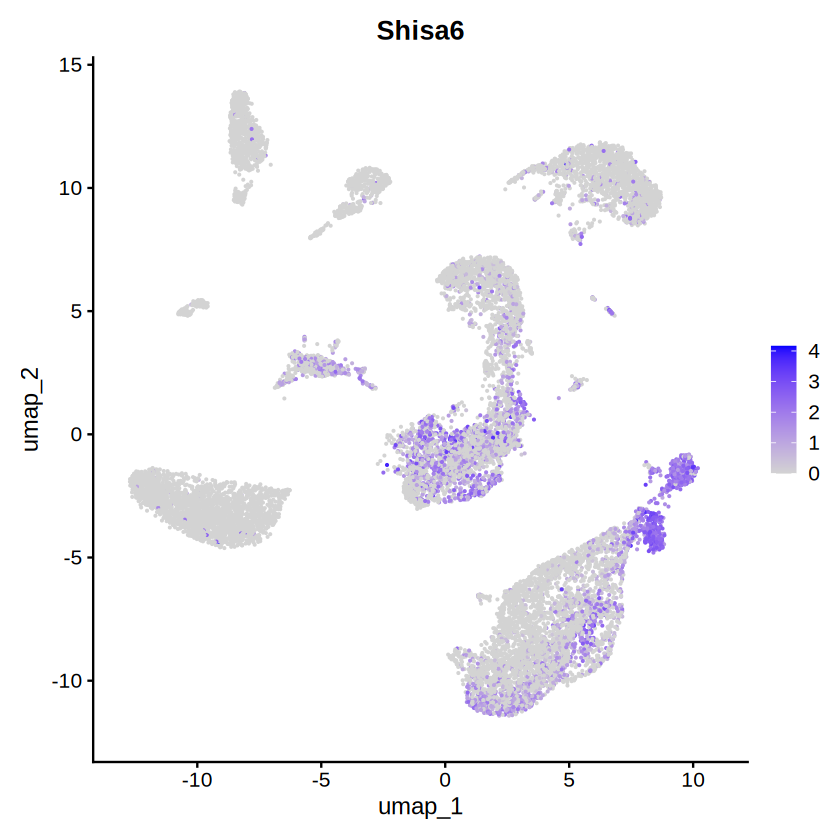

In [34]:

markers.cluster6 <- FindMarkers(cortexSubSO, ident.1 = 6)
FeaturePlot(cortexSubSO, features = head(rownames(markers.cluster6), 1))